## Разработка модели для оценки ДТП по выбранному маршруту движения.

Цель:   
Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
   
Условия:  
  
* Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
* Для модели выбрать тип виновника — только машина (car).
* Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
* Для моделирования ограничиться данными за 2012 год — они самые свежие.
* Обязательное условие — учесть фактор возраста автомобиля.
* На основе модели исследовать основные факторы ДТП.  

Основные вопросы от заказчика:
  
* Возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.
* Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
* Какие ещё факторы нужно учесть?
* Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics

from sqlalchemy import create_engine
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 

### Первичное исследование таблиц

Таблица case_ids


In [5]:
query = '''
SELECT * 
FROM case_ids
'''

case_id_df = pd.read_sql_query(query, con=engine)
case_id_df

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
...,...,...
1399995,5668365,2021
1399996,5668366,2021
1399997,5668367,2021
1399998,5668368,2021


In [6]:
case_id_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


In [7]:
# Выведем количество уникальных значений столбцов таблицы
case_id_df.nunique()

case_id    1400000
db_year          1
dtype: int64

* Таблица case_ids содержит год иницидента и уникальный ключ - "case_id".
* Всего в таблице 1400000 строк. Пропуски отсутствуют.
* Год выгрузки - 2021 год.

Таблица vehicles

In [8]:
query = '''
SELECT * 
FROM vehicles
'''

vehicles_df = pd.read_sql_query(query, con=engine)
vehicles_df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0
...,...,...,...,...,...,...
1021229,1175684,5304990,2,sedan,manual,6.0
1021230,1175686,5304993,2,sedan,manual,3.0
1021231,1175687,5304994,2,sedan,manual,3.0
1021232,1175693,5305002,1,sedan,manual,5.0


In [9]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


In [10]:
# Выведем количество уникальных значений столбцов таблицы "vehicles"
vehicles_df.nunique()

id                      1021234
case_id                  792642
party_number                 27
vehicle_type                  5
vehicle_transmission          2
vehicle_age                  22
dtype: int64

* Таблица vehicles содержит 6 столбцов.
* Всего в таблице 1021234 строк. Пропуски содержатся в столбцах vehicle_transmission и vehicle_age.

Таблица collisions

In [11]:
query_collisions = '''
SELECT *
FROM collisions
'''

collisions_df = pd.read_sql_query(query_collisions, con=engine)
collisions_df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399995,4082805,1502,kern,57.0,east,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with no street lights,none,2009-01-17,21:04:00
1399996,4082820,1953,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2009-01-18,14:20:00
1399997,4082829,1502,kern,0.0,None,1.0,clear,highway,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-17,18:06:00
1399998,4083008,4313,santa clara,20.0,east,NaN,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-06,17:53:00


In [12]:
collisions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

In [13]:
# Выведем количество уникальных значений столбцов таблицы "collisions"
collisions_df.nunique()

case_id                        1400000
county_city_location               538
county_location                     58
distance                          5071
direction                            4
intersection                         2
weather_1                            7
location_type                        3
collision_damage                     5
party_count                         18
primary_collision_factor             5
pcf_violation_category              23
type_of_collision                    7
motor_vehicle_involved_with          9
road_surface                         4
road_condition_1                     8
lighting                             5
control_device                       4
collision_date                    1550
collision_time                    1440
dtype: int64

* Таблица collisions содержит 1 внешний ключ - "case_id". Для данной таблицы, его можно считать также первичным.
* Таблица содержит 20 столбцов.
* Всего в таблице 1400000 строк.

Таблица parties

In [14]:
query_parties = '''
SELECT *
FROM parties
LIMIT 5
'''

parties_df = pd.read_sql_query(query_parties, con=engine)
parties_df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [15]:
# Нет возможности загрузить данную таблицу полностью, поэтому посмотрим лишь основную информацию о ней
parties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5 non-null      int64  
 1   case_id              5 non-null      object 
 2   party_number         5 non-null      int64  
 3   party_type           5 non-null      object 
 4   at_fault             5 non-null      int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       5 non-null      object 
 7   party_drug_physical  1 non-null      object 
 8   cellphone_in_use     5 non-null      int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 488.0+ bytes


* Таблица parties содержит 1 первичный ключ, и 1 внешний ключ - "case_id".
* Таблица содержит 9 столбцов.
* Всего в таблице 2752448 строк.

### Cтатистический анализ факторов ДТП

Анализ зависимости количества аварий от месяца ДТП

Посмотрим, какое количество ДТП было зафиксировано по годам:

In [16]:
query_year = '''SELECT extract(year from collision_date) as year_collision, COUNT(*)
FROM collisions
GROUP BY year_collision'''

print(pd.read_sql_query(query_year, con=engine))

   year_collision   count
0          2009.0  426228
1          2010.0  416490
2          2011.0  402428
3          2012.0  154547
4          2013.0     305
5          2020.0       2


Посмотрим на количество ДТП внутри каждого года по месяцам.

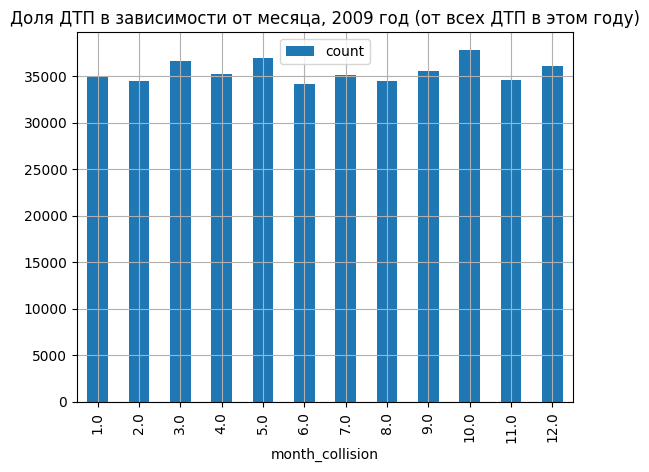

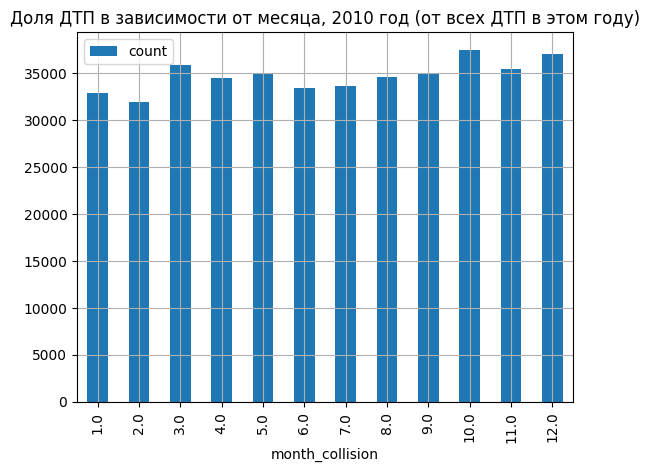

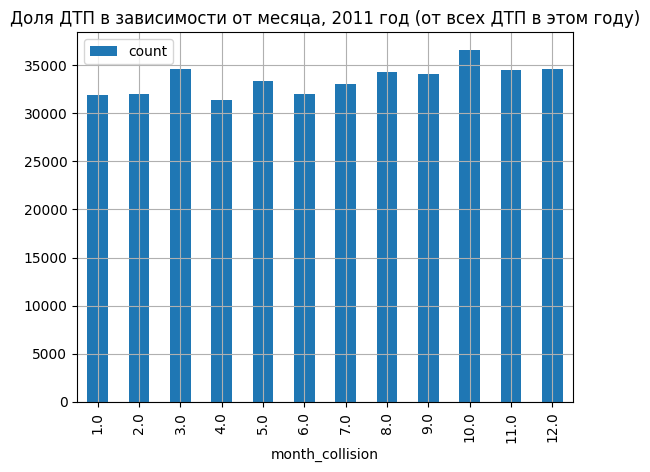

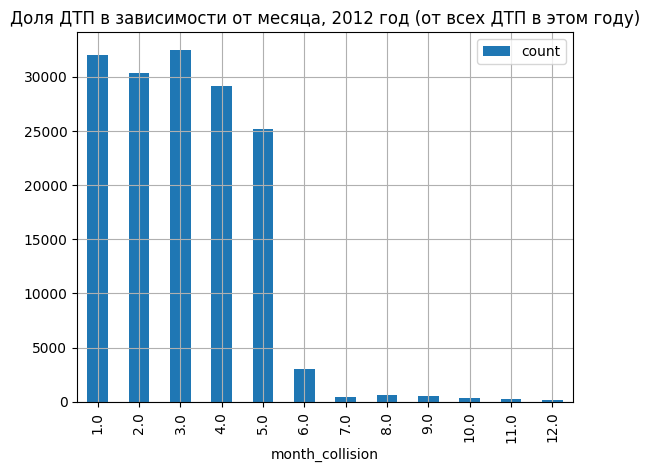

In [17]:
for i in [2009, 2010, 2011, 2012]:
    query = f'''SELECT extract(month from collision_date) as month_collision, COUNT(*)
    FROM collisions
    WHERE extract(YEAR from collision_date) = {i}
    GROUP BY month_collision'''

    pd.read_sql_query(query, con=engine, index_col='month_collision').plot.bar(grid=True)
    plt.title(f"Доля ДТП в зависимости от месяца, {i} год (от всех ДТП в этом году)")
    plt.show()

В среднем, в течение года наблюдается примерно одинаковое количество ДТП. Из месяцев, в которые количество происшествий чуть превышало среднее, можно выделить: март, октябрь, ноябрь, декабрь.   
В данных за 2012 год зафиксировано аномально низкое количество происшествий начиная с июня месяца. Сложно сказать, с чем это связано, но похоже на аномалию.   
Данные за 2013 и 2020 год не входили в анализ.

### Постановка задач для коллег

1) Изучите, влияют ли погодные условия на количество дорожно-транспортных происшествий? (таблица collisions)

2) Проведите анализ серьезности повреждений исходя из погодных условия на дороге в момент происшествия.

3) Проанализирйте, влияет ли уровень освещения на количество происшествий, а также на серьезность повреждения транспортного средства? (таблица collisions)

4) Проведите анализ и выясните, влияет ли возраст траспортного средства на тип аварии (таблицы collisions и vehicles)

Для этого:  
  
* Создайте SQL-запрос
* Сгруппируйте данные по типу аварии и выведите средний и медианный возраст для каждого типа
* Отобразите получившийся результат на графике (например, можно использовать "barplot")
* Сделайте вывод   
5) Проанализируйте, влияет ли тип кузова (седан, хэтчбэк и тд) траспортного средства на серьезность повреждения (collisions и vehicles)
   
Для этого:

* Создайте SQL-запрос
* Сгруппируйте данные по типу кузова. Для каждого типа посчитайте сколько раз встречалась та или иная категория повреждения
* Для удобства, распределение частоты встречаемости той или иной категории повреждения можно визуализировать на графике (для каждого типа кузова отдельный график)
* Сделайте вывод
6) Выясните, есть ли зависимость количества ДТП от физического состояния участников, а также влияет ли это состояние на серьезность повреждения транспортного средства? (таблицы collisions и parties)

### Создание модели для оценки водительского риска

#### Выявление признаков и выгрузка данных  
Прежде чем создать модель, выявим факторы, влияющие на целевой признак at_fault.
  
Таблица vehicles:

* vehicle_transmission - авто с МКПП может быть сложнее для неопытных водителей, использующих каршеринг.

Таблица parties:

* at_fault - целевой признак;
* cellphone_in_use - использование телефона снижает внимательность;
* party_sobriety - трезвость водителя;

Таблица collisions:

* weather_1 - погода;
* intersection - чаще всего, по статистике, ДТП происходят именно на перекрестках;
* pcf_violation_category- основная причина аварии, выявление причины позволит предотвращать аварии в будущем;
* motor_vehicle_involved_with - дополнительные участники ДТП, выявление наиболее частых участников позволит уменьшить число дтп;
* road_surface - состояние поверхности дороги - гололед, мокрая/скользкая/сухая дорога;
* control_device - наличие контролирующего утройства - неизвестный фактор, который модет оказать влияние
* lighting - освещенность дороги.

С помощью запроса выгрузим необходимые данные в таблицу. По условию задачи, нужны только данные за 2012 год, где участник аварии - машина и с повреждениями больше чем царапина.

In [18]:
query = '''
SELECT DISTINCT c.case_id,
       weather_1,
       pcf_violation_category,
       motor_vehicle_involved_with,
       road_surface,
       control_device,
       lighting,
       vehicle_transmission,
       cellphone_in_use, 
       party_sobriety,
       at_fault
FROM collisions c
inner JOIN parties p ON c.case_id = p.case_id inner JOIN vehicles v ON c.case_id = v.case_id 
WHERE (extract(YEAR FROM cast(collision_date AS date))::int = 2012
  AND party_type = 'car'
  AND collision_damage != 'scratch')
'''

df = pd.read_sql_query(query, con=engine) 
df.head()

,case_id,weather_1,pcf_violation_category,motor_vehicle_involved_with,road_surface,control_device,lighting,vehicle_transmission,cellphone_in_use,party_sobriety,at_fault
0,5125160,cloudy,automobile right of way,other motor vehicle,dry,none,daylight,auto,0.0,had not been drinking,0
1,5125160,cloudy,automobile right of way,other motor vehicle,dry,none,daylight,auto,0.0,had not been drinking,1
2,5173738,clear,speeding,other motor vehicle,dry,none,daylight,auto,0.0,had not been drinking,0
3,5173738,clear,speeding,other motor vehicle,dry,none,daylight,auto,0.0,had not been drinking,1
4,5269486,clear,unknown,other motor vehicle,dry,functioning,daylight,auto,0.0,had not been drinking,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91894 entries, 0 to 91893
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      91894 non-null  object 
 1   weather_1                    91628 non-null  object 
 2   pcf_violation_category       90577 non-null  object 
 3   motor_vehicle_involved_with  91642 non-null  object 
 4   road_surface                 91347 non-null  object 
 5   control_device               91534 non-null  object 
 6   lighting                     91642 non-null  object 
 7   vehicle_transmission         90327 non-null  object 
 8   cellphone_in_use             82795 non-null  float64
 9   party_sobriety               90461 non-null  object 
 10  at_fault                     91894 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 7.7+ MB


In [20]:
df.isna().sum()/len(df)

case_id                        0.000000
weather_1                      0.002895
pcf_violation_category         0.014332
motor_vehicle_involved_with    0.002742
road_surface                   0.005953
control_device                 0.003918
lighting                       0.002742
vehicle_transmission           0.017052
cellphone_in_use               0.099016
party_sobriety                 0.015594
at_fault                       0.000000
dtype: float64

Доля пропущенных значений < 10%, можем их удалить.

In [21]:
df = df.dropna()

Проверим на наличие полных дубликатов:

In [22]:
df.duplicated().sum()

0

Дубликаты отсутствуют, теперь можем удалить столбец с id:

In [23]:
df = df.drop('case_id', axis=1)

Посмотрим на значения в датафрейме:

In [24]:
df['lighting'].unique()

array(['daylight', 'dark with street lights', 'dusk or dawn',
       'dark with no street lights',
       'dark with street lights not functioning'], dtype=object)

Избавимся от пробелов в названиях и от слишком большого кол-ва категорий - присвоим значение dark всем категориям, обозначающим неосвещенную улицу.

In [25]:
def fix_value(cell):
    cell = cell.replace(' ', '_')
    return cell

In [26]:
df['lighting'] = df['lighting'].apply(lambda x: 'dark' if 'dark' in x else x)
df['lighting'] = df['lighting'].apply(fix_value)

То же самое сделаем с признаком party_sobriety, оставив только факт, был участник в состоянии опьянения или нет:

In [27]:
df['party_sobriety'].unique()

array(['had not been drinking', 'had been drinking, under influence',
       'had been drinking, impairment unknown',
       'had been drinking, not under influence', 'impairment unknown',
       'not applicable'], dtype=object)

In [28]:
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'sober' if 'had not' in x else x)
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'drunk' if 'had been' in x else x)
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'drunk' if 'impairment' in x else x)

df['party_sobriety'] = df['party_sobriety'].apply(fix_value)

Далее рассмотрим категории нарушений. Здесь можно обьединить нарушения правил пешеходами в одну группу, тк задача - рассмотреть причины только автомобильных аварий. Также можно объединить в одну категорию технические неисправности.

In [29]:
df['pcf_violation_category'].unique() 

array(['automobile right of way', 'speeding', 'unknown',
       'improper turning', 'other hazardous violation',
       'pedestrian violation', 'dui', 'pedestrian right of way',
       'traffic signals and signs', 'other than driver (or pedestrian)',
       'wrong side of road', 'improper passing', 'other improper driving',
       'unsafe lane change', 'hazardous parking', 'following too closely',
       'unsafe starting or backing', 'lights', 'impeding traffic',
       'other equipment', 'brakes', 'fell asleep'], dtype=object)

In [30]:
df['pcf_violation_category'] = df['pcf_violation_category'].apply(lambda x: 'equipment_fault' if x == 'brakes' 
                                                                  or x == 'other equipment'
                                                                  or x == 'lights' else x)
df['pcf_violation_category'] = df['pcf_violation_category'].apply(lambda x: 'pedestrian_involved' if x == 'automobile right of way' 
                                                                  or x == 'pedestrian violation' 
                                                                  or x == 'dui' 
                                                                  or x == 'other than driver (or pedestrian)'  
                                                                  or x == 'improper passing' else x)

df['pcf_violation_category'] = df['pcf_violation_category'].apply(fix_value)

In [31]:
df['motor_vehicle_involved_with'].unique() 

array(['other motor vehicle', 'other object', 'fixed object',
       'non-collision', 'bicycle', 'parked motor vehicle', 'train',
       'animal', 'motor vehicle on other roadway'], dtype=object)

In [32]:
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].apply(lambda x: 'other_vehicle' if x == 'other motor vehicle' 
                                                                  or x == 'motor vehicle on other roadway' else x)

df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].apply(lambda x: 'fixed object' if x == 'parked motor vehicle' else x)
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].apply(fix_value)

### Aнализ важности факторов ДТП  
Проведем простое кодирование категориальных признаков для оценки зависимостей:

In [33]:
categorial = ['weather_1', 
              'pcf_violation_category',
              'motor_vehicle_involved_with', 
              'road_surface',
              'control_device', 
              'lighting', 
              'vehicle_transmission', 
              'party_sobriety' ]

In [34]:
df_tmp = pd.get_dummies(df, columns=categorial, drop_first=True)

In [35]:
numeric =['cellphone_in_use']

scaler = StandardScaler()
scaler.fit(df_tmp[numeric])
df_tmp[numeric] = scaler.transform(df_tmp[numeric])

pd.options.mode.chained_assignment = None

Посмотрим на корелляцию признаков:

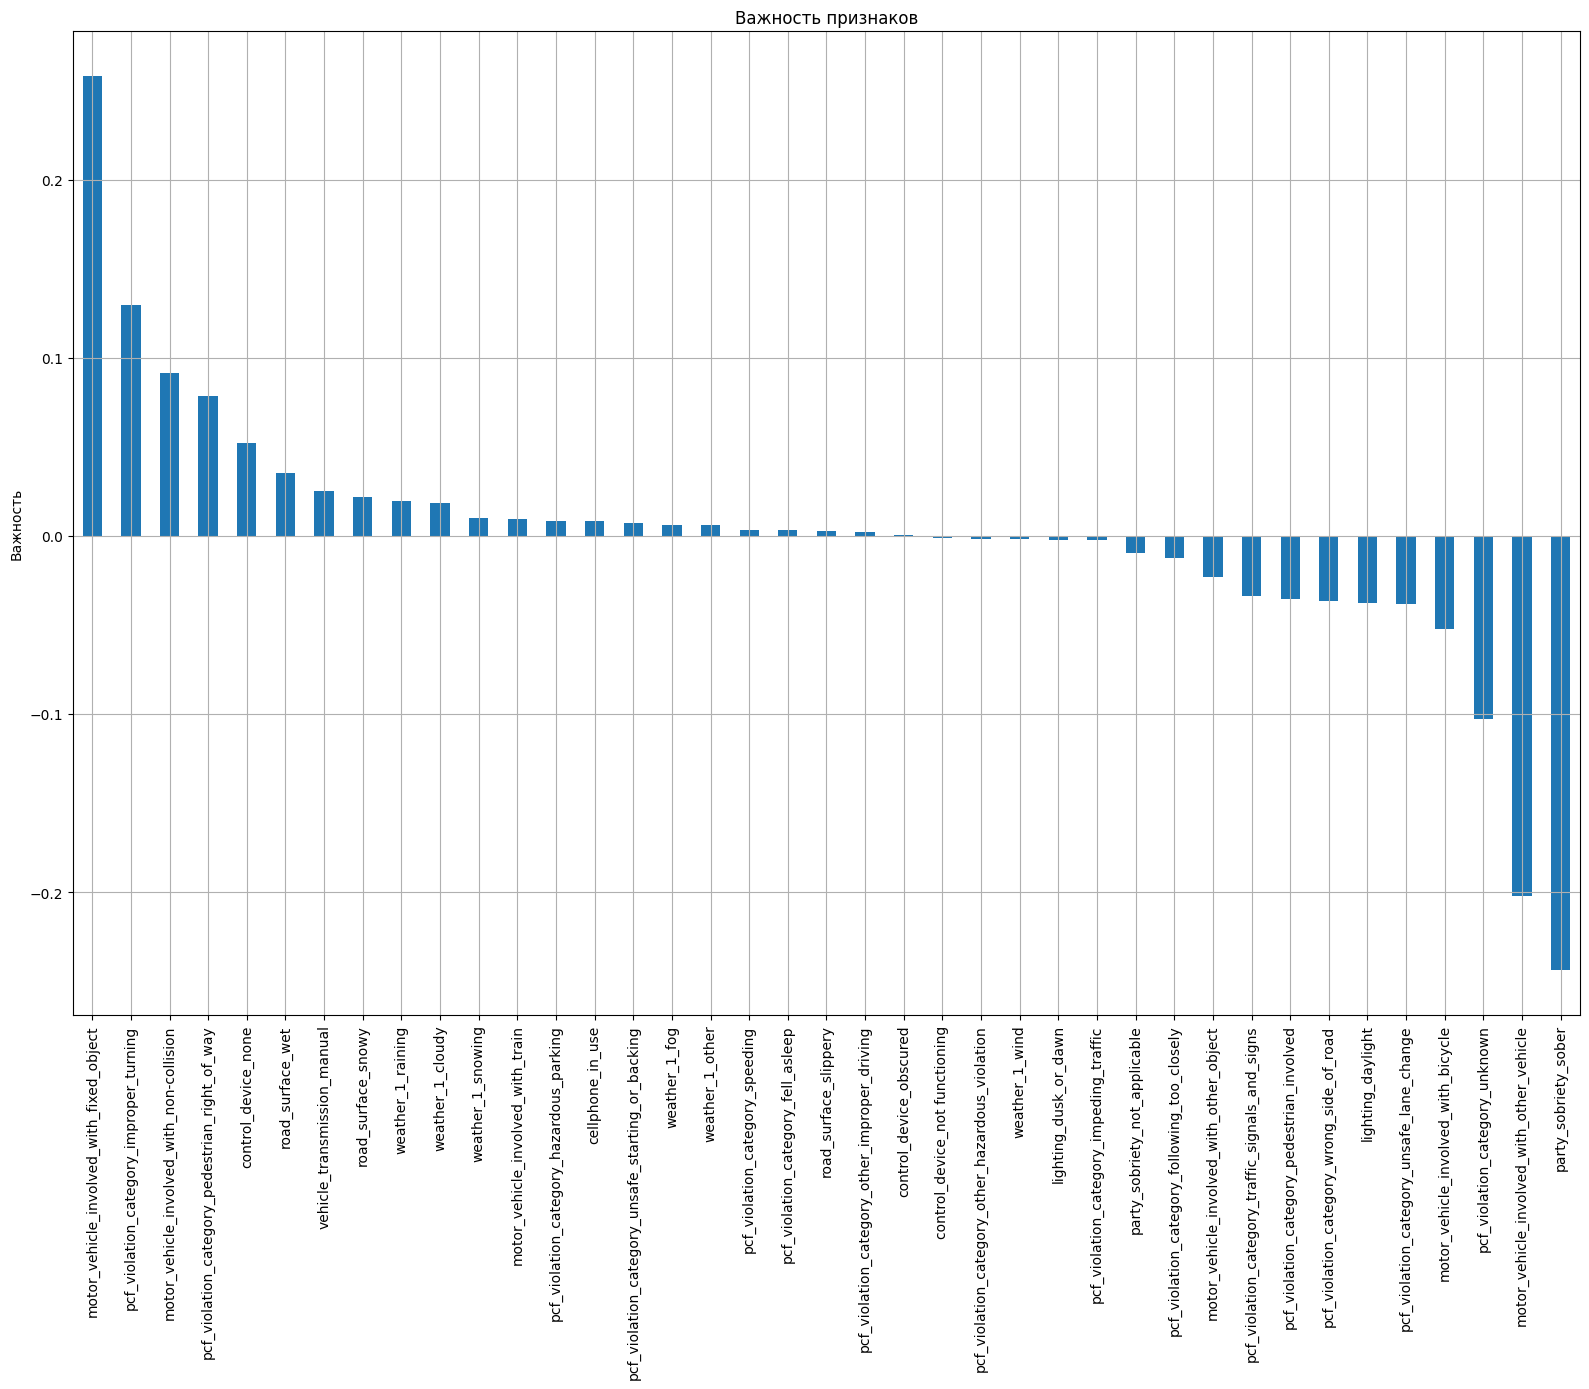

In [36]:
fig, ax = plt.subplots(figsize=(16,14))
df_tmp.corr().iloc[1].sort_values(ascending=False).drop('at_fault',axis = 0).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
plt.grid()

fig.tight_layout()

Из графика видим, что прямое влияние на виновность в ДТП оказывает:   

* Участие пьяных водителей
* Столкновения с неподвижными объектами
* Нарушения ПДД
* Мокрая дорога
* Автомобили с МКПП
* Использование телефона

Обратная зависимость:

* Трезвый водитель
* При дневном свете
* По вине пешеходов

### Разделение на выборки и кодирование признаков

In [37]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('at_fault', axis=1),
                                                    df['at_fault'],
                                                    train_size=0.8,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=df['at_fault'])

In [38]:
tmp_train = x_train[categorial]
tmp_test = x_test[categorial]

encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(x_train[categorial])

tmp_train = pd.DataFrame(encoder_ohe.transform(x_train[categorial]).toarray(),
                         columns=encoder_ohe.get_feature_names_out(),
                         index=x_train.index)
tmp_test = pd.DataFrame(encoder_ohe.transform(x_test[categorial]).toarray(),
                         columns=encoder_ohe.get_feature_names_out(),
                         index=x_test.index)

x_train.drop(categorial, axis=1, inplace=True)
x_train = x_train.join(tmp_train)

x_test.drop(categorial, axis=1, inplace=True)
x_test = x_test.join(tmp_test)

Посмотрим на баланс классов:

at_fault
1    0.532265
0    0.467735
Name: proportion, dtype: float64


<Axes: xlabel='at_fault'>

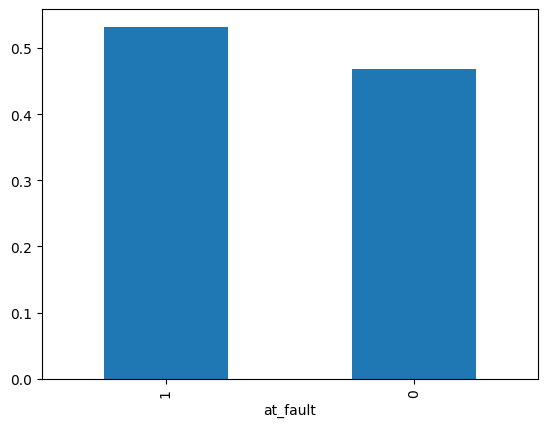

In [39]:
class_frequency = y_train.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

In [40]:
class_frequency[0]/class_frequency[1]

0.8787625916433213

Классы можно считать сбалансированными, распределние близко к 50%.
   
При сравнении моделей в качестве определяющей метрики будем использовать точность (precision), тк она показывает долю истинно положительных ответов.
   
Для вычисления метрик и построения графика определим функцию metrics_func:

In [41]:
def metrics_func(model):
    model.fit(x_train, y_train)
    predicted_test = model.predict(x_test)
    probabilities_test = model.predict_proba(x_test)
    probabilities_one_test = probabilities_test[:,1]
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    print('Точность:', precision)
    print('Полнота:', recall)
    print('Доля правильных ответов:', accuracy_score(y_test, predicted_test))
    print('F1-мера:', f1_score(y_test, predicted_test))
    print('AUC-ROC:', roc_auc_score(y_test, probabilities_one_test))
    print('Матрица ошибок:')
    print(confusion_matrix(y_test, predicted_test))
    
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
    
    plt.figure()
    
    plt.plot([0,1], [0,1], linestyle = '--')
    plt.plot(fpr, tpr)
    
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    
    plt.show()
    return precision, predicted_test, probabilities_one_test, model

Модель решающего дерева

In [42]:
params = {
    'max_depth':  range(1,15,2),
    'min_samples_leaf': range (1,12),
    'min_samples_split': range (2,14,2)
}

model = DecisionTreeClassifier()

grid = RandomizedSearchCV(model, 
                          param_distributions=params,
                          scoring='precision',
                          n_jobs=-1,
                          random_state=123)

grid.fit(x_train, y_train)

print(grid.best_params_)

{'min_samples_split': 6, 'min_samples_leaf': 8, 'max_depth': 9}


Точность: 0.8873517786561265
Полнота: 0.37465728930742637
Доля правильных ответов: 0.6418147208121827
F1-мера: 0.5268627944011398
AUC-ROC: 0.705824110004187
Матрица ошибок:
[[6972  399]
 [5246 3143]]


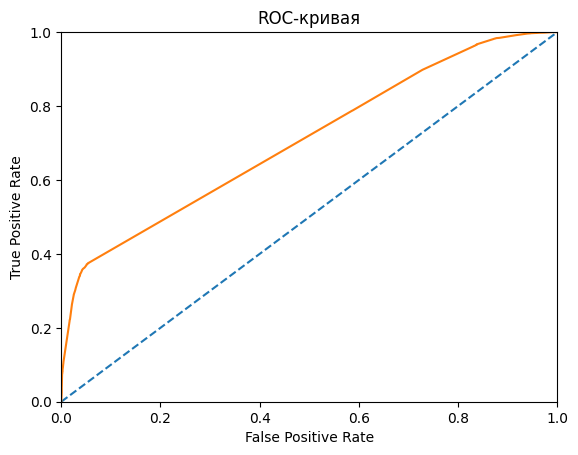

In [43]:
precision_dt, predictions_dt, probabilities_dt, model_dt  = metrics_func(DecisionTreeClassifier(max_depth=9, 
                                                                                             min_samples_split=6, 
                                                                                             min_samples_leaf=8, 
                                                                                             random_state=123,
                                                                                             class_weight='balanced'))

Модель случайного леса

In [44]:
params = {
    'max_depth':  range(1,15,2),
    'min_samples_leaf': range (1,12),
    'min_samples_split': range (2,14,2),
    'n_estimators': range(10,155,15)
}

model = RandomForestClassifier()

grid = RandomizedSearchCV(model, param_distributions=params,
                          scoring='precision',
                          n_jobs=-1,random_state=123)

grid.fit(x_train, y_train)

print(grid.best_params_)

{'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 13}


Точность: 0.8767123287671232
Полнота: 0.38145190129932055
Доля правильных ответов: 0.6421954314720812
F1-мера: 0.5316056150843094
AUC-ROC: 0.7017485023405474
Матрица ошибок:
[[6921  450]
 [5189 3200]]


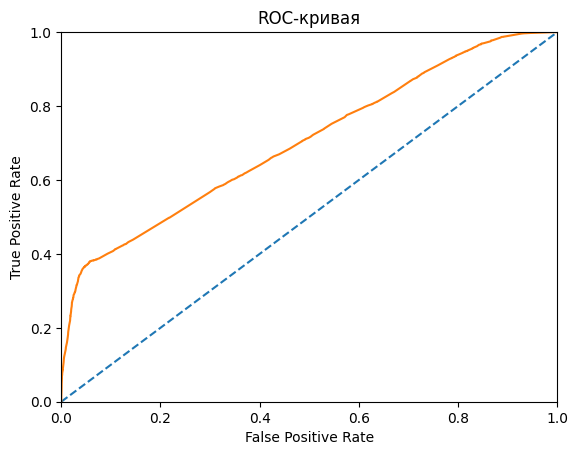

In [45]:
precision_rf, predictions_rf, probabilities_rf, model_rf = metrics_func(RandomForestClassifier(n_estimators=145, 
                                                                                 max_depth=13, 
                                                                                 min_samples_split=6, 
                                                                                 min_samples_leaf=4, 
                                                                                 random_state=123,
                                                                                 class_weight='balanced'))

LightGBM

In [46]:
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'num_leaves': range (2,50, 10)}
           
model = LGBMClassifier()

grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='precision', 
    n_jobs=-1, 
    random_state=123
)

grid.fit(x_train, y_train)

print(grid.best_params_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 33554, number of negative: 29486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 63040, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532265 -> initscore=0.129241
[LightGBM] [Info] Start training from score 0.129241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 33554, number of negative: 29486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 63040, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Точность: 0.884765625
Полнота: 0.37799499344379545
Доля правильных

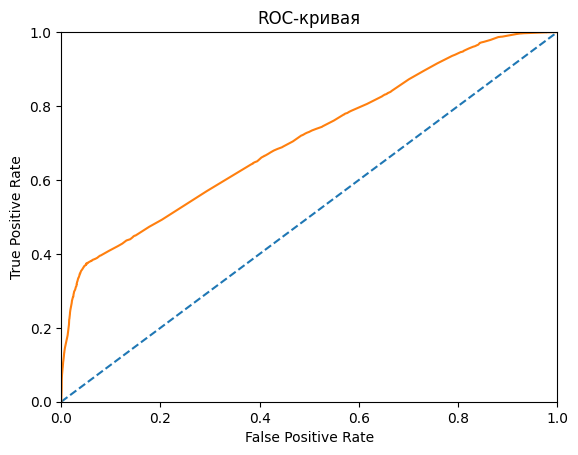

In [47]:
precision_lgbm, predictions_lgbm, probabilities_lgbm, model_lgbm = metrics_func(LGBMClassifier(boosting_type='gbdt',
                                                                                            random_state=123, 
                                                                                            max_depth=4,
                                                                                            n_estimators=100,
                                                                                            learning_rate = 0.1,
                                                                                            num_leaves = 12,
                                                                                            class_weight='balanced'))

Catboost

In [49]:
params =  {'iterations': range(100, 2600, 500),
           'depth': range (1,15)}
           
model = CatBoostClassifier(verbose=False)

grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='precision', 
    n_jobs=-1, 
    random_state=123
)

grid.fit(x_train, y_train)

print(grid.best_params_)

Точность: 0.8611184733633713
Полнота: 0.38729288353796637
Доля правильных ответов: 0.6406091370558376
F1-мера: 0.5342871238283177
AUC-ROC: 0.7066648673713481
Матрица ошибок:
[[6847  524]
 [5140 3249]]


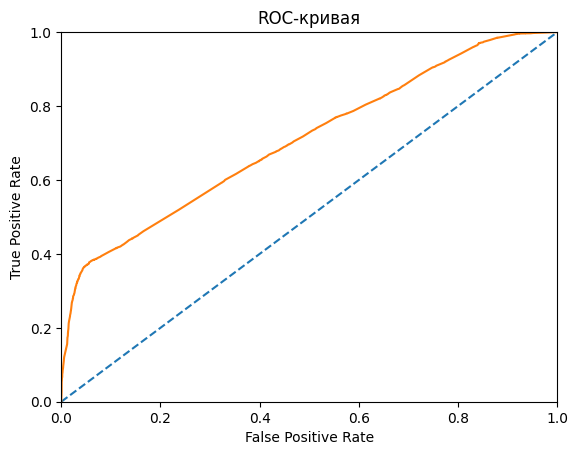

In [48]:
precision_cb, predictions_cb, probabilities_cb, model_cb = metrics_func(CatBoostClassifier(depth=5,
                                                                                        iterations=1100,
                                                                                        random_seed=60,
                                                                                        learning_rate=0.003, 
                                                                                        verbose=False))

Проверим адекватность моделей на пустышке:

Точность: 0.5322969543147208
Полнота: 1.0
Доля правильных ответов: 0.5322969543147208
F1-мера: 0.694769969771005
AUC-ROC: 0.5
Матрица ошибок:
[[   0 7371]
 [   0 8389]]


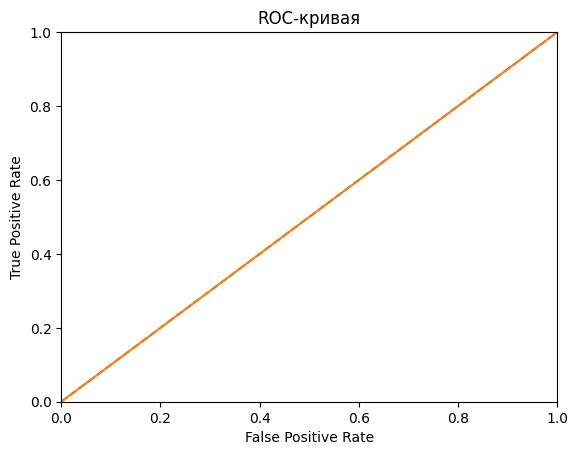

In [49]:
precision_dumm, predictions_dumm, probabilities_dumm, model_dumm  = metrics_func(DummyClassifier(strategy='most_frequent'))

Все модели имеют примерно схожие показатели.

Оформим результат в виде таблицы:

In [50]:
result = pd.DataFrame ([
    [precision_dt],
    [precision_rf],
    [precision_lgbm],
    [precision_cb],
    [precision_dumm]], 
    columns=['precision'],
    index=['DecisionTree','RandomForest', 'LightGBM', 'CatBoost', 'Dummy'])
result.sort_values(by='precision', ascending=False)

,precision
DecisionTree,0.887352
LightGBM,0.884766
RandomForest,0.876712
CatBoost,0.861118
Dummy,0.532297


Наибольшее значение точности имеет модель DecisionTree - 0.887352.

### Анализ лучшей модели

Матрица ошибок для модели DecisionTree:

In [51]:
confusion_matrix(y_test, predictions_dt)

array([[6972,  399],
       [5246, 3143]], dtype=int64)

Здесь, как и на матрицах для остальных моделей, мы видим высокое число ложно-положительных ответов, и при этом малое число ложно-отрицательных - лучше ошибочно прездсказать аварийную ситуацию, чем ошибочно не предсказать.

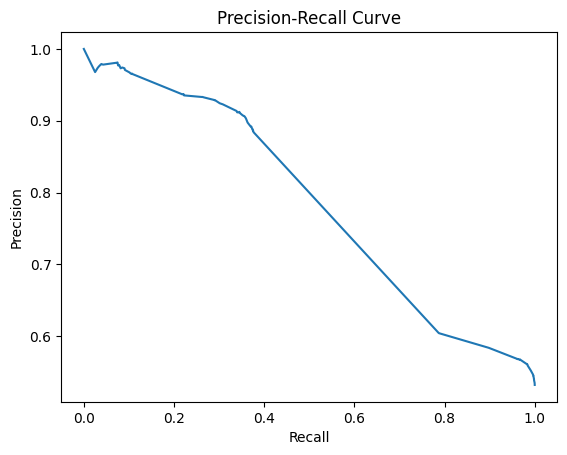

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_dt)

fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

Проанализируем важность основных факторов, влияющих на вероятность ДТП:

In [53]:
smf = SelectFromModel(model_dt, threshold=-np.inf, max_features = 25)
smf.fit(x_train, y_train)
features_index = smf.get_support()
features_1 = x_train.columns[features_index]
features_1

Index(['weather_1_clear', 'pcf_violation_category_equipment_fault',
       'pcf_violation_category_following_too_closely',
       'pcf_violation_category_improper_turning',
       'pcf_violation_category_other_hazardous_violation',
       'pcf_violation_category_other_improper_driving',
       'pcf_violation_category_pedestrian_involved',
       'pcf_violation_category_pedestrian_right_of_way',
       'pcf_violation_category_speeding', 'pcf_violation_category_unknown',
       'pcf_violation_category_unsafe_lane_change',
       'pcf_violation_category_wrong_side_of_road',
       'motor_vehicle_involved_with_animal',
       'motor_vehicle_involved_with_bicycle',
       'motor_vehicle_involved_with_fixed_object',
       'motor_vehicle_involved_with_non-collision',
       'motor_vehicle_involved_with_other_object',
       'motor_vehicle_involved_with_other_vehicle', 'road_surface_dry',
       'control_device_functioning', 'control_device_none', 'lighting_dark',
       'lighting_daylight', 

Можно выявить наиболее важные факторы, влияющие на вероятность ДТП:

Факт алкогольного опьянения
Столкновение с объектом
Освещенность улицы
Наезд на пешехода, когда пешеход имел приемущество
Мокрая дорога
Рассмотрим один из факторов, и построим график зависимости фактора и целевой переменной:

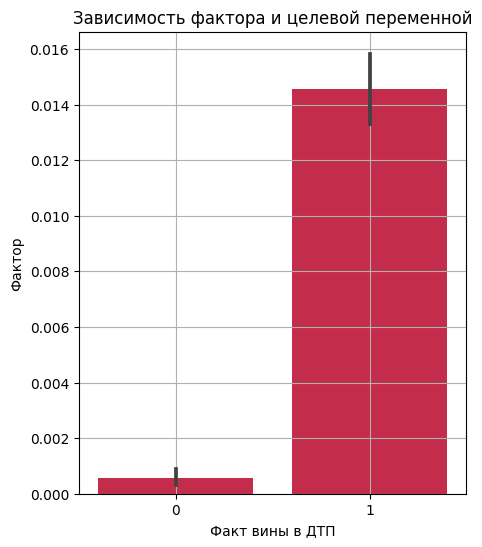

In [54]:
plt.figure(figsize=[5,6])
sns.barplot(x=y_train, y=x_train['pcf_violation_category_pedestrian_right_of_way'], color='crimson')
plt.title('Зависимость фактора и целевой переменной')
plt.xlabel('Факт вины в ДТП')
plt.ylabel('Фактор')
plt.grid()
plt.show()

Здесь мы взяли признак pedestrian_right_of_way, что можно истолковать как ДТП, где преимущество было у пешехода. Чтобы предотвратить подобные случаи, рекомендуется оборудовать автомобили встроенным навигатором, предупреждающем об ограничениях скорости и автоматической коробкой передач.

### Выводы
Создание системы оценки водительского риска вероятно, однако стоит учитывать не только внешние факторы, такие как состояние дорожного покрытия или освещенность улицы, но некоторые данные касающиеся самого водителя, такие как стаж, участие в дтп в качестве виновника ранее и тд. Также стоит в будущем учитывать плотность движения. Для повышения безопасности рекомендуется оборудовать автомобили системой экстренного торможения